In [1]:
import sys
sys.path.append("/home/vblot/multiaccurate_cp/")

In [2]:
import os
import yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import minimize
from sklearn.model_selection import KFold
from tqdm import tqdm

from multiaccurate_cp.utils.multiaccurate import J, J_prime

%load_ext autoreload
%autoreload 2


In [3]:
DATASET = "polyp"
BASE_DIR = f"/home/vblot/multiaccurate_cp/data/{DATASET}"
MODELS_PATH = f"/home/vblot/multiaccurate_cp/data/{DATASET}/03_model_weights/resnet"
MODEL_NAME = "20240325_1446"

In [4]:
# Specify the path to the YAML file
file_path = os.path.join(MODELS_PATH, MODEL_NAME, "config.yaml")

# Read the YAML file
with open(file_path, "r") as file:
    config = yaml.safe_load(file)


In [5]:
config

{'mean_RGB_values_path': None,
 'ml_data_dir': 'data/polyp/02_prepared_data',
 'model': {'batch_size': 40,
  'embedding_size': 1024,
  'epochs': 100,
  'lr': 0.0001,
  'model_input': 'image_and_probas',
  'num_workers': 8,
  'patience': 20,
  'resnet': 'resnet50',
  'target_recall': 0.9},
 'output_dir': 'data/polyp/03_model_weights/resnet',
 'polyp': True,
 'probas_dir': 'data/polyp/04_predictions'}

In [6]:
IMG_SIZE = 64
EMBEDDING_SIZE = config["model"]["embedding_size"]

In [7]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_RES_EMB = os.path.join(BASE_DIR, "04_predictions/cal/res_embeddings", MODEL_NAME)
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_RES_EMB = DIR_CAL_RES_EMB.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")


In [8]:
def load_data(pred_probas_dir, res_emb_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    res_emb = np.zeros((len(os.listdir(res_emb_dir)), EMBEDDING_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, res_emb_file, label_file) in enumerate(tqdm(zip(sorted(os.listdir(pred_probas_dir)),
                                                                       sorted(os.listdir(res_emb_dir)),
                                                                       sorted(os.listdir(labels_dir))))):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        res_emb[i] = np.load(os.path.join(res_emb_dir, res_emb_file))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, res_emb, labels


In [9]:
c_pp, c_re, c_l = load_data(DIR_CAL_PRED_PROBAS, DIR_CAL_RES_EMB, DIR_CAL_LABELS)


252it [00:00, 818.59it/s]


In [10]:
t_pp, t_re, t_l = load_data(DIR_TEST_PRED_PROBAS, DIR_TEST_RES_EMB, DIR_TEST_LABELS)

546it [00:00, 938.78it/s] 


In [11]:
all_pred_probas = np.concatenate([c_pp, t_pp])
all_res_emb = np.concatenate([c_re, t_re])
all_labels = np.concatenate([c_l, t_l])

all_pred_probas.shape, all_res_emb.shape, all_labels.shape

((798, 64, 64), (798, 1024), (798, 64, 64))

In [12]:
ALPHA = .1

In [13]:
recalls = []
precisions = []

for _ in tqdm(range(100)):
    cal_inx = np.random.choice(range(len(all_pred_probas)), len(all_pred_probas) // 2 , replace=False)
    test_inx = np.array([i for i in range(len(all_pred_probas)) if i not in cal_inx])
    temp_cal_pred_probas = all_pred_probas[cal_inx]
    temp_cal_res_emb = all_res_emb[cal_inx]
    temp_cal_labels = all_labels[cal_inx]
    temp_test_pred_probas = all_pred_probas[test_inx]
    temp_test_res_emb = all_res_emb[test_inx]
    temp_test_labels = all_labels[test_inx]

    n = len(temp_cal_pred_probas)

    result = minimize(
        J, np.random.uniform(0, 1, EMBEDDING_SIZE),
        method="SLSQP",
        args=(temp_cal_labels, temp_cal_pred_probas, temp_cal_res_emb, ALPHA, n), jac=J_prime,
        options={"disp": False, "maxiter": 10000}
    )

    ths = np.maximum((temp_test_res_emb @ result.x).reshape(-1, 1, 1), -np.inf)
    y_pred_test_th = (temp_test_pred_probas >= ths).astype(int)
    recall_test = (y_pred_test_th * temp_test_labels).sum(axis=(1, 2)) / temp_test_labels.sum(axis=(1, 2))
    precision_test = np.nan_to_num((y_pred_test_th * temp_test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)
    recalls.append(np.nanmean(recall_test))
    precisions.append(np.nanmean(precision_test))
    print(np.nanmean(recall_test))

    


0it [00:00, ?it/s]/tmp/ipykernel_2915570/1544859823.py:26: RuntimeWarning: invalid value encountered in divide
  precision_test = np.nan_to_num((y_pred_test_th * temp_test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)
1it [01:01, 61.54s/it]

0.8384983072668574


2it [02:30, 77.91s/it]

0.8292471418302746


3it [03:28, 68.45s/it]

0.88671931258586


4it [03:29, 41.82s/it]

1.0


Exception ignored in: <function _releaseLock at 0x7fe9de8c7be0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 9.]),
 array([0.91433997, 0.92290597, 0.93147197, 0.94003798, 0.94860398,
        0.95716998, 0.96573599, 0.97430199, 0.98286799, 0.991434  ,
        1.        ]),
 <BarContainer object of 10 artists>)

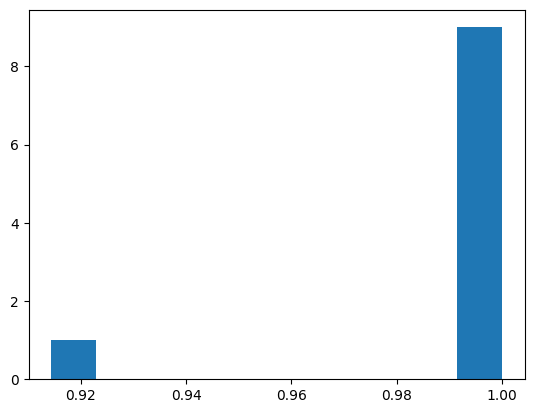

In [ ]:
plt.hist(recalls)

In [ ]:
np.mean(recalls)

0.9914339967008704

(array([2., 5., 1., 1., 0., 0., 0., 0., 0., 1.]),
 array([0.05529476, 0.06909726, 0.08289976, 0.09670225, 0.11050475,
        0.12430725, 0.13810974, 0.15191224, 0.16571474, 0.17951723,
        0.19331973]),
 <BarContainer object of 10 artists>)

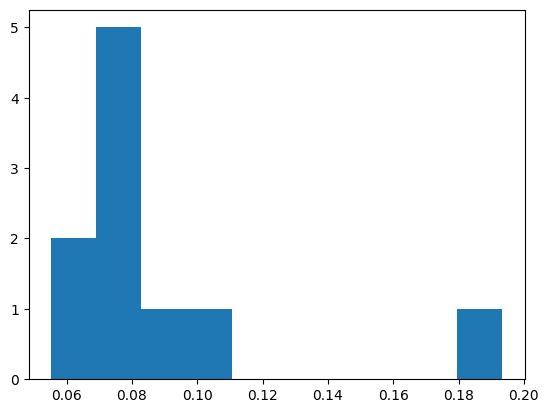

In [ ]:
plt.hist(precisions)

In [ ]:
np.unique(ths)

array([-2.3227777 , -2.27589949, -2.25461115, -2.25048395, -2.24854904,
       -2.2334106 , -2.22169288, -2.20807043, -2.20802603, -2.20531569,
       -2.19370115, -2.17963712, -2.15545727, -2.14683098, -2.13128815,
       -2.12930914, -2.10046943, -2.09800542, -2.0973925 , -2.0925508 ,
       -2.08839042, -2.07545525, -2.06968204, -2.06610773, -2.05209287,
       -2.04208333, -2.03970324, -2.03194283, -2.02293694, -2.00760604,
       -2.00150385, -1.99835579, -1.99769033, -1.99565236, -1.99490753,
       -1.99176835, -1.990518  , -1.98441362, -1.98290165, -1.98140777,
       -1.96910063, -1.96901516, -1.94650777, -1.93702763, -1.93583741,
       -1.93477091, -1.92063976, -1.91790095, -1.91628851, -1.90954809,
       -1.90061527, -1.89551611, -1.89425738, -1.88978166, -1.88814882,
       -1.87938543, -1.87693577, -1.864814  , -1.86396438, -1.86233427,
       -1.85174882, -1.85035414, -1.8413587 , -1.82533899, -1.82111133,
       -1.81816337, -1.81004277, -1.80756906, -1.80096138, -1.78

In [ ]:
ths

array([[[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0.01]],

       [[0